In [112]:
from torchvision import models
import numpy as np
import cv2
import PIL

from pytorch_grad_cam import GradCAM,GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image

import torch

In [113]:
# class ModifiedResNet50(models.ResNet):
#     def __init__(self):
#         super(ModifiedResNet50, self).__init__(models.resnet.Bottleneck, [3, 4, 6, 3])
#         self.fc = torch.nn.Linear(2048, 2)  # Modify the final fully connected layer for your specific task

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.fc(x)  # Pass through the modified fully connected layer
#         return x

# # Create the modified model instance
# model = ModifiedResNet50()
# model.eval()

In [114]:
model = models.resnet50(pretrained=True)
model.eval()

# Modify the fully connected layer for your specific task
num_classes = 2  # Modify this based on your classification task
model.fc = torch.nn.Linear(2048, num_classes)


/Users/liviamurray/opt/anaconda3/envs/552env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/liviamurray/opt/anaconda3/envs/552env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [115]:
# use the pretrained ResNet50 model
# model = models.resnet50(pretrained=True)
# model.eval()


In [116]:
# fix target class label (of the Imagenet class of interest!)
# 1: goldfish, 250: Siberian Husky, 947: mushroom

# targets = [ClassifierOutputTarget(<target-class-number>)] 
targets = [ClassifierOutputTarget(1)] 

# fix the target layer (after which we'd like to generate the CAM)
target_layers = [model.layer4]

In [117]:
# instantiate the model
cam = GradCAM(model=model, target_layers=target_layers) # use GradCamPlusPlus class

# Preprocess input image, get the input image tensor
# img = np.array(PIL.Image.open('/Users/liviamurray/552_ALproj/800px-Common_goldfish.JPG'))
img = np.array(PIL.Image.open('/Users/liviamurray/552_ALproj/goldfish2.jpeg'))

img = cv2.resize(img, (300,300))
img = np.float32(img) / 255
# input_tensor = preprocess_image(img)

In [118]:
# cv2.imshow('Normal Image', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [119]:
input_tensor = preprocess_image(img)

# generate CAM
grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

cam = np.uint8(255*grayscale_cams[0, :])

cam = cv2.merge([cam, cam, cam])

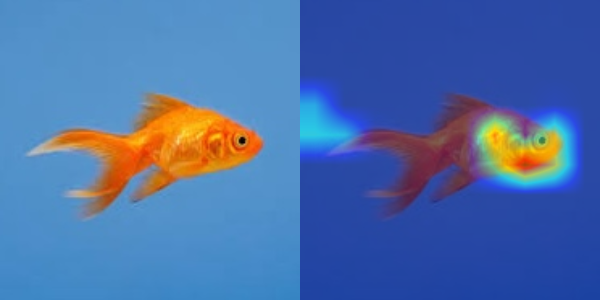

In [120]:
# display the original image & the associated CAM
images = np.hstack((np.uint8(255*img), cam_image))
PIL.Image.fromarray(images)

## HERE BELOW BROKEN:

In [121]:
# Define the location and size of the region to apply the blur
x, y, w, h = (200, 100, 50, 50)  # Example: x and y are the coordinates of the top-left corner, w and h are the width and height

# Extract the region of interest (ROI) from the image
roi = img[y:y+h, x:x+w]

# Apply Gaussian blur to the ROI
blurred_roi = cv2.GaussianBlur(roi, (15, 15), 0)  # Adjust the kernel size (e.g., (15, 15)) for desired blur intensity

# Replace the original ROI with the blurred version
blurr_img = img.copy()
blurr_img[y:y+h, x:x+w] = blurred_roi

# Display the image with the blurred region
# cv2.imshow('Blurred Image', blurr_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [122]:
input_tensor2 = preprocess_image(blurr_img)

# generate CAM
grayscale_cams = cam(input_tensor=input_tensor2, targets=targets)
cam_image = show_cam_on_image(blurr_img, grayscale_cams[0, :], use_rgb=True)

cam = np.uint8(255*grayscale_cams[0, :])

cam = cv2.merge([cam, cam, cam])

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
# display the original image & the associated CAM
images = np.hstack((np.uint8(255*blurr_img), cam_image))
PIL.Image.fromarray(images)

In [ ]:
def add_noise(img, mean=0, std=0.1):
    noise = np.random.normal(mean, std, img.shape)
    noisy_img = img + noise
    return np.clip(noisy_img, 0, 1)

# Add noise to the input image
noisy_img = add_noise(img)

# Preprocess the noisy input image and convert it to a tensor
input_tensor3 = preprocess_image(noisy_img)

targets = [ClassifierOutputTarget(1)]  # Assuming binary classification task
grayscale_cams = cam(input_tensor=input_tensor3, targets=targets)

# Convert CAM to RGB format for overlaying
cam_image = show_cam_on_image(noisy_img, grayscale_cams[0], use_rgb=True)

# Convert CAM to RGB format for overlaying
cam_rgb = cv2.cvtColor(cam_image, cv2.COLOR_GRAY2RGB)

# Overlay CAM on the original image
overlay_image = cv2.addWeighted((img * 255).astype(np.uint8), 0.5, cam_rgb, 0.5, 0)

# Display the overlayed image
PIL.Image.fromarray(overlay_image)